In [1]:
# Ritter IPO Analysis
#   Import, Clean, Engineer Features for Ritter IPO datasets
# pip install wget

#imports
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import wget

In [2]:
# Download Ritter IPO 2609 file
ipo2609_filename = "IPO2609.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO2609.xls"
wget.download(url, ipo2609_filename)

100% [............................................................................] 828416 / 828416

'IPO2609.xls'

In [3]:
# Download Ritter IPO 1526 file
ipo1526_filename = "IPO1526.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO1526.xls"
wget.download(url, ipo1526_filename)

100% [..........................................................................] 1399808 / 1399808

'IPO1526.xls'

In [4]:
# Read IPO 2609 Excel file into dataframe
# NOTE:  YOu can igore WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
df = pd.read_excel(ipo2609_filename, sheet_name='ipo2609')

# Convert Categorical
#   Zip
#      Replace 0, 999 with NA
df['zip'] = df['zip'].astype(str).str.ljust(5,'0')
df['zip'] = df['zip'].replace(
    to_replace=['00000', '99900'],
    value='NA')
#      Add trailing zeros so 5 digits
df['zip'] = pd.Categorical(df['zip'])
#      Use zip3 for region
df['zip3'] = df['zip'].str[:3]
df['zip3'] = pd.Categorical(df['zip3'])

df['t'] = pd.Categorical(df['t'])
#   Type
#      There are two NA values 0,9.  Replace with NA
df['t'] = df['t'].replace(
    to_replace=[0, 9],
    value='NA')
df['t'] = df['t'].replace(
    to_replace=[1],
    value='Best Efforts')
df['t'] = df['t'].replace(
    to_replace=[2],
    value='Firm Committment')
df['t'] = df['t'].replace(
    to_replace=[3],
    value='Combination')
df['t'] = pd.Categorical(df['t'])
#   Exchange
df['ex'] = df['ex'].replace(
    to_replace=[1],
    value='NASDAQ')
df['ex'] = df['ex'].replace(
    to_replace=[2],
    value='AMEX')
df['ex'] = df['ex'].replace(
    to_replace=[3],
    value='NYSE')
df['ex'] = df['ex'].replace(
    to_replace=[4],
    value='Non-NASDAQ OTC')   
df['ex'] = pd.Categorical(df['ex'])
#   SIC Code
df['sic'] = pd.Categorical(df['sic'])
#   Lead Underwriter
#      Replace 0 with NA
df['uw1'] = df['uw1'].replace(
    to_replace=['0'],
    value='NA')
df['uw1'] = pd.Categorical(df['uw1'])
#   Year Organized
#     Replace 00, 01 with 1 (Before 1900, so mark them 1901 )
#     NOTE: No rows meet this condition
df['yr'] = df['yr'].replace(
    to_replace=['00', '01'],
    value='1')
#     Replace 99 with NA
df['yr'] = df['yr'].replace(
    to_replace=['99'],
    value='NA')
df['yr'] = pd.Categorical(df['yr'])
df['yr'].describe()
#   Security Type: Last two digits of CUSIP represent security type
df['sectype'] = df['cusip'].astype(str).str[-2:]
df['sectype'] = pd.Categorical(df['sectype'])

# Convert and scale decimals
#   Offering Price 7.3
df['op'] = df['op'].astype(float) / 1000
#   Closing bid on first aftermarket day 9.5
df['pr1'] = df['pr1'].astype(float) / 100000
# Calculate D1 percent change in price
df['d1pctchg'] = (df['pr1'] - df['op']) / df['op'] * 100
# Replace inf from Divide by Zero with NaN
i = df[np.isinf(df['d1pctchg'])].index
df.loc[i, 'd1pctchg'] = np.NaN
df['underpriced'] = df['d1pctchg'] > 0
#   Value of S&P on Closing Date 5.2
df['sp'] = df['sp'].replace(
    to_replace=[99999],
    value=np.NaN)
df['sp'] =df['sp'].astype(float) / 100
#   Aftermarket standard deviation
df['uncer'] = df['uncer'].replace(
    to_replace=[999],
    value=np.NaN)
df['uncer'] =df['uncer'].astype(float) / 1000
#   Continuousely compounded growth rate
df['gs'] = df['gs'].replace(
    to_replace=[999],
    value=np.NaN)
df['gs'] =df['gs'].astype(float) / 1000
#   Offering as a fraction of shares outstanding
df['of'] = df['of'].replace(
    to_replace=[999],
    value=np.NaN)
df['of'] =df['of'].astype(float) / 100

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


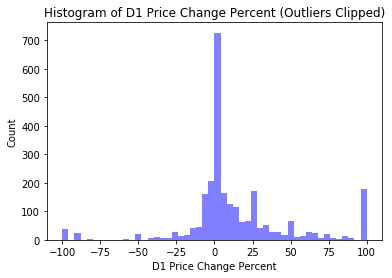

In [5]:
# Plot a Histogram of D1 Price Change Percent
# Remove NaN and Clip Outliers
clipped= np.clip(df['d1pctchg'][~np.isnan(df['d1pctchg'])], -100, 100)
num_bins = 50
n, bins, patches = plt.hist(clipped, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('D1 Price Change Percent')
plt.ylabel('Count')
plt.title(r'Histogram of D1 Price Change Percent (Outliers Clipped)')
plt.show()

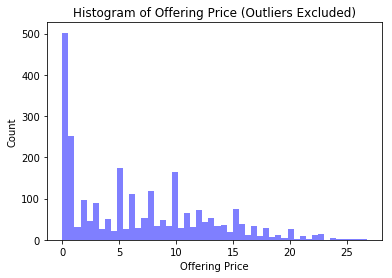

In [6]:
# Simple Outlier implementation based on z-score
def is_outlier(points, thresh=3.0):

    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


# Plot a Histogram of Offering Price excluding outliers
filtered = df['op'][~is_outlier(df['op'])]
num_bins = 50
n, bins, patches = plt.hist(filtered, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Offering Price')
plt.ylabel('Count')
plt.title(r'Histogram of Offering Price (Outliers Excluded)')
plt.show()

In [7]:
# Join IPO1526 (36 month returns for CRSP-listed)
# Parse columns returns cusip, name and 38 months of returns
df_1526 = pd.read_excel(ipo1526_filename, sheetname='ipo1526', usecols='A,S:BE')

# Fix Cusip Data Errors
#  Cusip 23322D10 should be 23322410
df_1526.loc[df_1526['cusip'] == '23322D10', 'cusip'] = '23322410'
#  Cusip 25469E10 should be 25469510
df_1526.loc[df_1526['cusip'] == '25469E10', 'cusip'] = '25469510'
#  Cusip 29265H10 should be 29265110
df_1526.loc[df_1526['cusip'] == '29265H10', 'cusip'] = '29265110'
# Cusip 29270H10 should be 29291810
df_1526.loc[df_1526['cusip'] == '29270H10', 'cusip'] = '29291810'
# There are too many Cusip errors, so we will join on Name
#df_1526['cusip'] = df_1526['cusip'].astype(int)
# Rename name to Name so it matches column in ipo2609
df_1526 = df_1526.rename(columns={'name': 'Name'})

# Replace missing values -100 with NaN for all 38 month return columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526[r_col_name] = df_1526[r_col_name].mask(np.isclose(df_1526[r_col_name].values, -99.99998))


# Calculate 12, 24 and 36 month returns
df_1526['r12_sum'] = df_1526.iloc[:,1:13].sum(axis=1)
df_1526['r24_sum'] = df_1526.iloc[:,1:25].sum(axis=1)
df_1526['r36_sum'] = df_1526.iloc[:,1:37].sum(axis=1)

# Drop Cusip Column
df_1526.drop('cusip', inplace=True, axis=1)

# Drop r1-r38 columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526.drop(r_col_name, inplace=True, axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [8]:
# Merge on Name
# NOTE: We lose 10 rows, which we will accept for this experiment
df_merged = pd.merge(df, df_1526, on='Name')

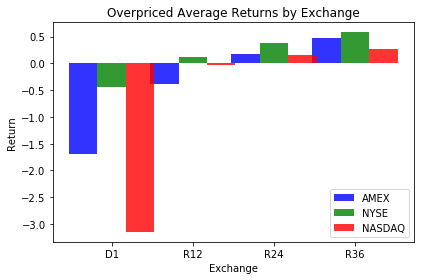

In [9]:
# Plot Bar Charts of Average Returns by Exchange for Overpriced and underpriced

#    Overpriced Chart
df_bar = df_merged[['underpriced', 'ex', 'd1pctchg', 'r12_sum', 'r24_sum', 'r36_sum']]
df_bar = df_bar.groupby(['underpriced', 'ex']).mean()
df_over_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_over_amex = df_over_amex.values.tolist()[0]
df_over_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_over_nyse = df_over_nyse.values.tolist()[0]
df_over_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_over_nasdaq = df_over_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df_over_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_over_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_over_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Overpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

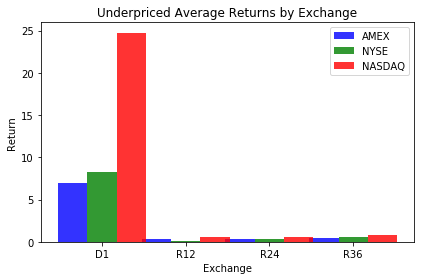

In [10]:
#    UnderPriced Chart
df_under_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_under_amex = df_under_amex.values.tolist()[0]
df_under_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_under_nyse = df_under_nyse.values.tolist()[0]
df_under_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_under_nasdaq = df_under_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
rects1 = plt.bar(index, df_under_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_under_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_under_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Underpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

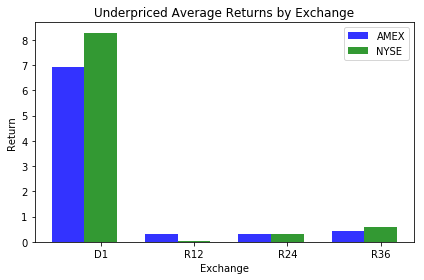

In [11]:
# Underpriced Exclude NASDAQ)
fig, ax = plt.subplots()
index = np.arange(n_groups)
rects1 = plt.bar(index, df_under_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_under_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Underpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()